In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.data_gen import * 
from utils.functions import *

Ambient dimension d = 20
Target support ys shape: (64, 20)


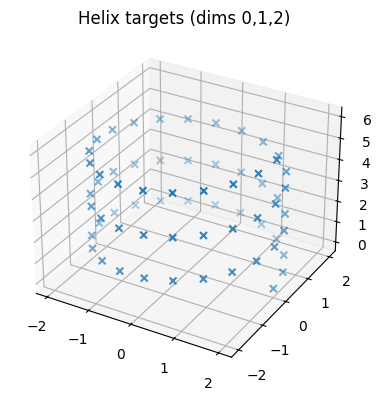

Computing Kantorovich potential phi on helix...
[OT dual] iter   250/2500, F ≈ 10.3192
[OT dual] iter   500/2500, F ≈ 10.7622
[OT dual] iter   750/2500, F ≈ 10.9334
[OT dual] iter  1000/2500, F ≈ 10.9768
[OT dual] iter  1250/2500, F ≈ 11.2152
[OT dual] iter  1500/2500, F ≈ 11.5591
[OT dual] iter  1750/2500, F ≈ 11.6640
[OT dual] iter  2000/2500, F ≈ 11.8657
[OT dual] iter  2250/2500, F ≈ 11.8995
[OT dual] iter  2500/2500, F ≈ 11.9892
Done. phi shape: (64,)


In [2]:
# ============================================================
# 1) Main High dimensional helix target
# ============================================================

rng = np.random.default_rng(0)

# Experiment parameters
d = 20                 # ambient dimension
n_points_helix = 64    # number of target support points
n_samples = 4096       # trajectories for sensitivity
n_traj = 256           # trajectories for plotting in PCA
n_steps = 1000         # ODE steps
n_iters_ot = 2500      # OT dual iterations
batch_size_ot = 2048
lr_ot = 0.05
eps_smooth = 0.5       # epsilon for smoothed Hopf Lax
sigma_list = [0.0, 0.02, 0.05, 0.1, 0.2]

print("Ambient dimension d =", d)
target_color = ['#081B1F']
ot_color = ['#017C01']
sbp_color = ['#C5036F']
initial_samples_color = ['#606C6C']
# --------------------------------------------------------
# 2) Build semi discrete helix target
# --------------------------------------------------------
ys = make_helix_targets(
    n_points=n_points_helix,
    d=d,
    radius=2.0,
    height=6.0,
    cycles=3.0,
)
N, dim = ys.shape
nu = np.ones(N, dtype=np.float64) / N
print("Target support ys shape:", ys.shape)

# quick sanity check in 3d (dims 0,1,2)
fig = plt.figure(figsize=(5, 4))
ax3d = fig.add_subplot(111, projection="3d")
ax3d.scatter(ys[:, 0], ys[:, 1], ys[:, 2], s=25, marker="x")
ax3d.set_title("Helix targets (dims 0,1,2)")
plt.tight_layout()
plt.show()

# --------------------------------------------------------
# 3) Approximate Kantorovich potential phi (semi discrete OT dual)
# --------------------------------------------------------
print("Computing Kantorovich potential phi on helix...")
phi = compute_kantorovich_potential(
    ys,
    nu,
    n_iters=n_iters_ot,
    batch_size=batch_size_ot,
    lr=lr_ot,
    seed=0,
    verbose=True,
)
phi_clean = phi.copy()
print("Done. phi shape:", phi_clean.shape)

# --------------------------------------------------------
# 2.3) Define clean OT and robust drifts
# --------------------------------------------------------

def v_ot_clean(x, t, phi_clean=phi_clean):
    return velocity_ot(x, t, phi_clean, ys)

def v_rob_clean(x, t, phi_clean=phi_clean):
    return velocity_robust(x, t, phi_clean, ys, eps_smooth=eps_smooth)

# --------------------------------------------------------
# 2.4) Sample base points in R^d and compute clean endpoints
# --------------------------------------------------------

# same X0 for all sigma
x0_fixed = sample_base(n_samples, d, rng)
xT_ot_clean = simulate_ode(v_ot_clean, x0_fixed, n_steps=n_steps)
xT_rob_clean = simulate_ode(v_rob_clean, x0_fixed, n_steps=n_steps)

# a smaller set of trajectories for PCA visualization
x0_traj = sample_base(n_traj, d, rng)
path_ot_clean = simulate_ode_path(v_ot_clean, x0_traj, n_steps=500)
path_rob_clean = simulate_ode_path(v_rob_clean, x0_traj, n_steps=500)


In [ ]:
# ============================================================
#  Run ONE helix sensitivity experiment (single seed)
# ============================================================
def run_single_helix_sensitivity(seed, sigma_list, d=20):
    rng = np.random.default_rng(seed)

    # ODE, OT-dual, and SBP parameters
    n_points_helix = 64
    n_samples = 4096
    n_steps = 1000
    n_iters_ot = 2500
    batch_size_ot = 2048
    lr_ot = 0.05
    eps_smooth = 0.5

    # Build helix target
    ys = make_helix_targets(
        n_points=n_points_helix, d=d,
        radius=2.0, height=6.0, cycles=3.0
    )

    # Solve dual for phi
    phi = compute_kantorovich_potential(
        ys,
        n_iters=n_iters_ot,
        batch_size=batch_size_ot,
        lr=lr_ot,
        seed=seed,
        verbose=False
    )
    phi_clean = phi.copy()

    # Drift functions (clean)
    def v_ot_clean(x, t, phi=phi_clean):
        return velocity_ot(x, t, phi, ys)

    def v_rob_clean(x, t, phi=phi_clean):
        return velocity_robust(x, t, phi, ys, eps_smooth=eps_smooth)

    # X0 samples
    x0_fixed = sample_base(n_samples, d, rng)

    # Clean endpoints
    xT_ot_clean = simulate_ode(v_ot_clean, x0_fixed, n_steps=n_steps)
    xT_rob_clean = simulate_ode(v_rob_clean, x0_fixed, n_steps=n_steps)

    # Compute robustness curve
    sens_ot = []
    sens_rob = []

    for sigma in sigma_list:

        if sigma > 0:
            phi_tilde = phi_clean + rng.normal(scale=sigma, size=phi_clean.shape)
        else:
            phi_tilde = phi_clean.copy()

        def v_ot_noisy(x, t, phi=phi_tilde):
            return velocity_ot(x, t, phi, ys)

        def v_rob_noisy(x, t, phi=phi_tilde):
            return velocity_robust(x, t, phi, ys, eps_smooth=eps_smooth)

        xT_ot_noisy = simulate_ode(v_ot_noisy, x0_fixed, n_steps=n_steps)
        xT_rob_noisy = simulate_ode(v_rob_noisy, x0_fixed, n_steps=n_steps)

        # endpoint sensitivity
        err_ot = endpoint_sensitivity(xT_ot_clean, xT_ot_noisy)
        err_rob = endpoint_sensitivity(xT_rob_clean, xT_rob_noisy)

        sens_ot.append(err_ot)
        sens_rob.append(err_rob)

    return np.array(sens_ot), np.array(sens_rob)


# ============================================================
#  Run K runs and compute mean +- std
# ============================================================

K=10
sigma_list=[0.0, 0.02, 0.05, 0.1, 0.2]
d=20
# save_pdf_path="helix_sensitivity.pdf"

sigma_array = np.array(sigma_list, dtype=np.float64)

all_ot = []
all_rob = []

print("Running helix experiment K times...")
for k in range(K):
    print(f"\n=== Run {k+1}/{K} ===")
    seed = k
    sens_ot, sens_rob = run_single_helix_sensitivity(seed, sigma_list, d=d)
    all_ot.append(sens_ot)
    all_rob.append(sens_rob)

all_ot = np.stack(all_ot, axis=0)     # shape (K, len(sigma_list))
all_rob = np.stack(all_rob, axis=0)

# compute mean and std
mean_sens_ot = all_ot.mean(axis=0)
std_sens_ot  = all_ot.std(axis=0, ddof=1)

mean_sens_rob = all_rob.mean(axis=0)
std_sens_rob  = all_rob.std(axis=0, ddof=1)





Running helix experiment K times...

=== Run 1/10 ===


In [ ]:
# ============================================================
# Plot mean +- std envelope
# ============================================================
band_factor = 1.0

fig, ax = plt.subplots(figsize=(6, 4))

# OT band
ax.fill_between(
    sigma_array,
    mean_sens_ot - band_factor * std_sens_ot,
    mean_sens_ot + band_factor * std_sens_ot,
    color=ot_color[0],
    alpha=0.15,
    linewidth=1,
    label="OT ± 1 std"
)

# SBP band
ax.fill_between(
    sigma_array,
    mean_sens_rob - band_factor * std_sens_rob,
    mean_sens_rob + band_factor * std_sens_rob,
    color=sbp_color[0],
    alpha=0.15,
    linewidth=1,
    label="SBP ± 1 std"
)

# lines on top
ax.plot(
    sigma_array, mean_sens_ot,
    marker="o", color=ot_color[0],
    label="OT mean"
)
ax.plot(
    sigma_array, mean_sens_rob,
    marker="s", color=sbp_color[0],
    label="SBP mean"
)

ax.set_xlabel(r"Noise level $\sigma$ on $\varphi$")
ax.set_ylabel(r"Mean squared endpoint displacement")
# ax.set_title(f"Helix in $\mathbb{{R}}^{d}$ (averaged over K={K} runs)")
ax.legend()
ax.grid(alpha=0.3)

fig.tight_layout()
fig.savefig('results/sensitivity_high_helix.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
from sklearn.decomposition import PCA

# ============================================================
# Time slice trajectories for helix in d = 20 via PCA
# ============================================================

# No noise case: use clean phi
phi_tilde = phi_clean

def v_ot_clean_fn(x, t, phi_tilde=phi_tilde):
    return velocity_ot(x, t, phi_tilde, ys)

def v_rob_clean_fn(x, t, phi_tilde=phi_tilde):
    return velocity_robust(x, t, phi_tilde, ys, eps_smooth=eps_smooth)

# First, get endpoints at t = 1 for PCA fit
xT_ot_final  = simulate_ode(v_ot_clean_fn,  x0_fixed, n_steps=n_steps, t0=0.0, t1=1.0)
xT_rob_final = simulate_ode(v_rob_clean_fn, x0_fixed, n_steps=n_steps, t0=0.0, t1=1.0)

# Stack a representative cloud for PCA
all_points = np.vstack([
    ys,
    x0_fixed,
    xT_ot_final,
    xT_rob_final,
])

pca = PCA(n_components=2)
pca.fit(all_points)

# Project targets once
ys_2d = pca.transform(ys)

# Choose 10 evenly spaced times
time_points = np.linspace(0.0, 1.0, 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, t_visual in enumerate(time_points):
    print(f"\n=== Time = {t_visual:.3f} ===")

    # simulate from t = 0 to t = t_visual in R^d
    xT_ot  = simulate_ode(v_ot_clean_fn,  x0_fixed, n_steps=n_steps, t0=0.0, t1=t_visual)
    xT_rob = simulate_ode(v_rob_clean_fn, x0_fixed, n_steps=n_steps, t0=0.0, t1=t_visual)

    # project to 2d
    xT_ot_2d  = pca.transform(xT_ot)
    xT_rob_2d = pca.transform(xT_rob)

    ax = axes[idx]

    ax.scatter(
        xT_ot_2d[:, 0], xT_ot_2d[:, 1],
        s=15, marker="o", alpha=0.4,
        label="OT", c=ot_color[0] if isinstance(ot_color, (list, tuple)) else ot_color
    )
    ax.scatter(
        xT_rob_2d[:, 0], xT_rob_2d[:, 1],
        s=15, marker="^", alpha=0.15,
        label="SBP", c=sbp_color[0] if isinstance(sbp_color, (list, tuple)) else sbp_color
    )
    ax.scatter(
        ys_2d[:, 0], ys_2d[:, 1],
        s=60, marker="x", linewidths=2, c=["#081B1F"]
    )

    ax.set_aspect("equal")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f"t = {t_visual:.2f}")

# Optional: only put legend on one panel
axes[0].legend(loc="upper right", fontsize=8)

plt.tight_layout()
fig.savefig(
    f"results/trajectories_helix_pca.pdf",
    format="pdf",
    bbox_inches="tight"
)
plt.show()


In [ ]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xT_ot_clean[:,0], xT_ot_clean[:,1], xT_ot_clean[:,2], s=2)
ax.scatter(ys[:,0], ys[:,1], ys[:,2], s=30, marker='x')
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3d projection
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 3d time slice trajectories for helix in R^d (no noise)
# ============================================================

phi_tilde = phi_clean

def v_ot_clean_fn(x, t, phi_tilde=phi_tilde):
    return velocity_ot(x, t, phi_tilde, ys)

def v_rob_clean_fn(x, t, phi_tilde=phi_tilde):
    return velocity_robust(x, t, phi_tilde, ys, eps_smooth=eps_smooth)

# First get endpoints at t = 1 for global bounds
xT_ot_final  = simulate_ode(v_ot_clean_fn,  x0_fixed, n_steps=n_steps, t0=0.0, t1=1.0)
xT_rob_final = simulate_ode(v_rob_clean_fn, x0_fixed, n_steps=n_steps, t0=0.0, t1=1.0)

# Collect points in dims 0,1,2 to set common axis limits
pts_bounds = np.vstack([
    ys[:, :3],
    x0_fixed[:, :3],
    xT_ot_final[:, :3],
    xT_rob_final[:, :3],
])
mins = pts_bounds.min(axis=0)
maxs = pts_bounds.max(axis=0)
center = 0.5 * (mins + maxs)
radius = 0.5 * np.max(maxs - mins)

x_lim = (center[0] - radius, center[0] + radius)
y_lim = (center[1] - radius, center[1] + radius)
z_lim = (center[2] - radius, center[2] + radius)

# Time grid
time_points = np.linspace(0.0, 1.0, 10)

fig = plt.figure(figsize=(15, 6))

for idx, t_visual in enumerate(time_points):
    print(f"\n=== Time = {t_visual:.3f} ===")

    # simulate in R^d
    xT_ot  = simulate_ode(v_ot_clean_fn,  x0_fixed, n_steps=n_steps, t0=0.0, t1=t_visual)
    xT_rob = simulate_ode(v_rob_clean_fn, x0_fixed, n_steps=n_steps, t0=0.0, t1=t_visual)

    # take first 3 coordinates
    xT_ot_3  = xT_ot[:, :3]
    xT_rob_3 = xT_rob[:, :3]
    ys_3     = ys[:, :3]

    ax = fig.add_subplot(2, 5, idx + 1, projection="3d")

    # colors (fall back if ot_color, sbp_color are simple strings)
    ot_c = ot_color[0] if isinstance(ot_color, (list, tuple)) else ot_color
    sbp_c = sbp_color[0] if isinstance(sbp_color, (list, tuple)) else sbp_color

    ax.scatter(
        xT_ot_3[:, 0], xT_ot_3[:, 1], xT_ot_3[:, 2],
        s=5, marker="o", alpha=0.4, c=ot_c, label="OT" if idx == 0 else None
    )
    ax.scatter(
        xT_rob_3[:, 0], xT_rob_3[:, 1], xT_rob_3[:, 2],
        s=5, marker="^", alpha=0.2, c=sbp_c, label="SBP" if idx == 0 else None
    )
    ax.scatter(
        ys_3[:, 0], ys_3[:, 1], ys_3[:, 2],
        s=35, marker="x", linewidths=2, c="#000000"
    )

    ax.set_xlim(*x_lim)
    ax.set_ylim(*y_lim)
    ax.set_zlim(*z_lim)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title(f"t = {t_visual:.2f}")

    if idx == 0:
        ax.legend(loc="upper right", fontsize=7)

plt.tight_layout()
fig.savefig(
    "results/helix_3d_timeslices_clean.pdf",
    format="pdf",
    bbox_inches="tight"
)
plt.show()
